## Implement Makemore to learn neural nets

makemore is a character level language model 

based on https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2

In [1]:
from pathlib import Path
import requests
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

### Get original data

In [2]:
data_dir = Path('/Users/djemec/data/gpt_train_data/')
#dest = data_dir / 'tiny_shakespeare' / 'input.txt'
names_url = "https://github.com/karpathy/makemore/raw/refs/heads/master/names.txt"
dest = data_dir / 'names' / 'names.txt'
#dest.write_bytes(requests.get(names_url, timeout=30).content)

In [3]:
# remove empty lines and makes all things lower case
with open(dest) as f:
    lines = [ln.rstrip('\n').lower() for ln in f if ln.strip()]

In [4]:
print(lines[:5])
print(len(lines))
print(f'longest {max(len(l) for l in lines)} | shortest {min(len(l) for l in lines)}')


['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033
longest 15 | shortest 2


In [5]:
# *lines forces character level
special_chars = ['.']
chars = sorted(list(set().union(*lines)) + special_chars)
vocab_size = len(chars) 

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

print(f'total vocab {vocab_size} | chars: {chars}') 

total vocab 27 | chars: ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Learning from here

In [306]:
# build frequency array of charcter followed by character.  arrays are rows X cols

# need a row and column for each char, int since count array
N = torch.zeros((vocab_size, vocab_size), dtype=torch.int32) 

# build frequency
b = {}
for w in lines:
    # add start line and end line tokens
    chs = ['.'] + list(w) + ['.']
    
    # iterate through each pairing 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

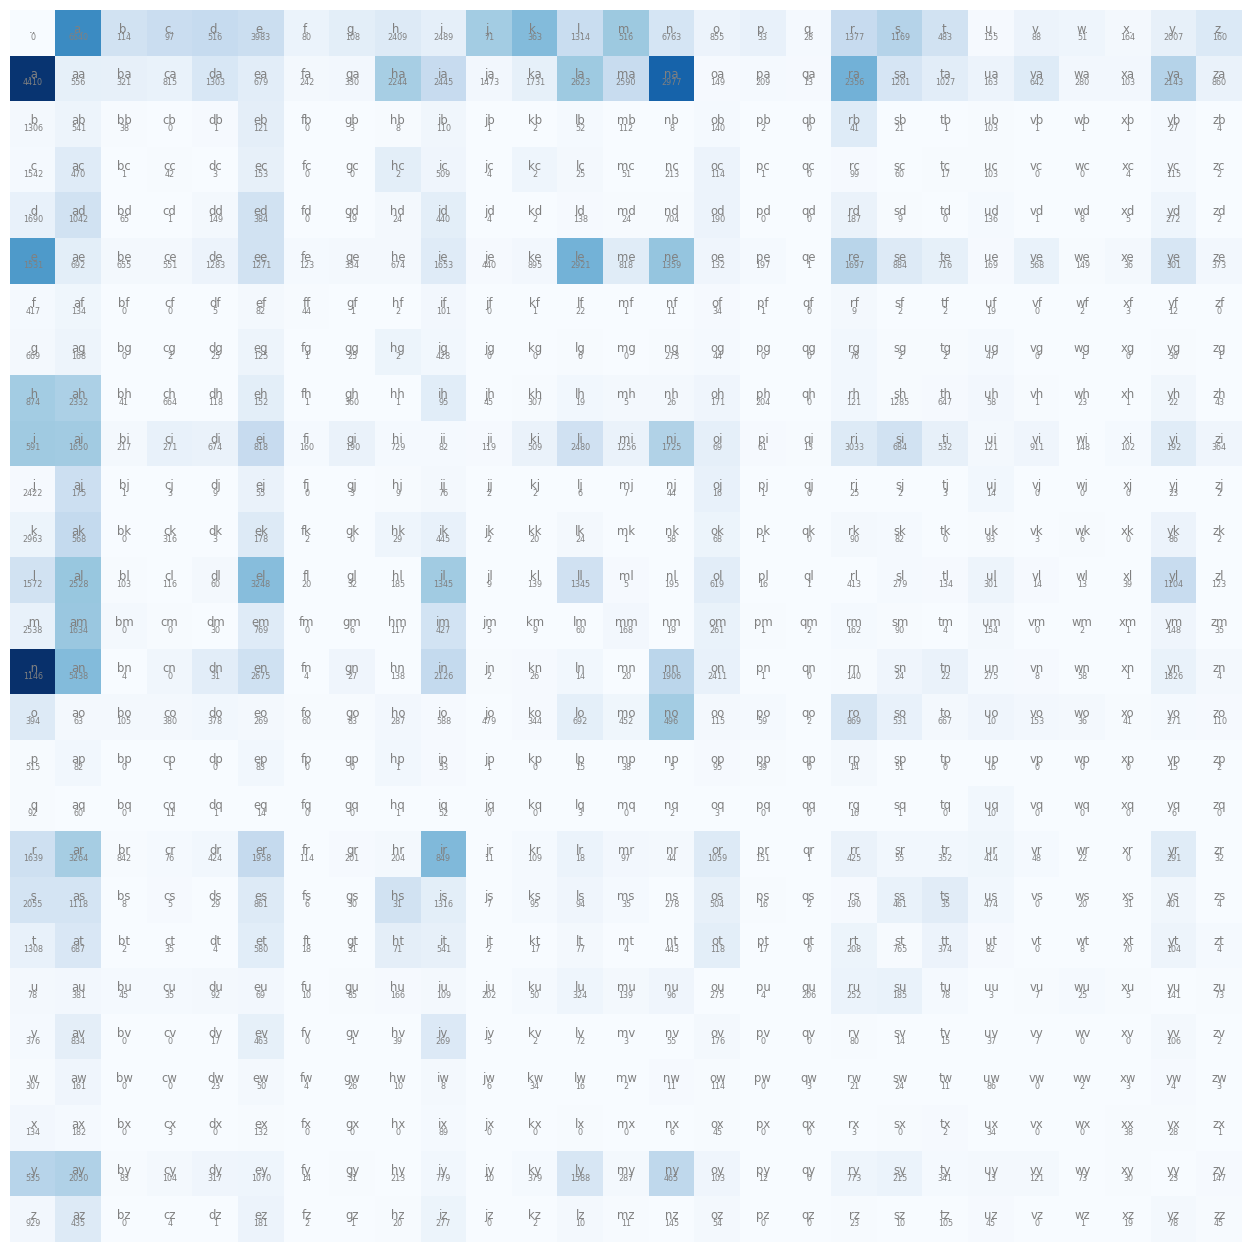

In [307]:
# heatmap of the array
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itos[i] + itos[j]
        chstr = chstr.replace('$', r'\$')
        plt.text(i,j, chstr, ha='center', color='gray', fontsize='small')
        plt.text(i,j, N[i,j].item(), ha='center', va='top', color='gray', fontsize='xx-small')
plt.axis('off')

In [308]:
# names start with . so get the row that starts with . 

print(N[0])
# convert to probabilities
p = N[0].float()
p = p/p.sum()
p

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)


tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [309]:
g = torch.Generator().manual_seed(12345)
# sample from p 
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

's'

## Bigram Language Model

Kinda sucks if you look at it

In [310]:
# make each row the probability
# add 1 to each occurrence to ensure there's no blowup to 'inf' during loss. for smoothing
P = (N+1).float()
#since broadcasted, it expands the sum dimension on the dimension that's 1. 
P /= P.sum(1,keepdim=True)

In [311]:
g = torch.Generator().manual_seed(12345678)

# start at 0 since the 0th row is the one that starts with '.'

for i in range(20):
    gen_name = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        gen_name.append(itos[ix])
        if ix == 0:
            break
    
    print(''.join(gen_name))

calemegaryn.
ka.
osen.
n.
nigheyrcon.
th.
wol.
nsl.
badeeler.
hs.
sa.
ghadey.
kasocensemoralllun.
bess.
jeidyans.
min.
zalen.
kailiridg.
pren.
disigiriahane.


## Evaluate how good the model is

To evaluate how good the model is we have to look at the probabilities of the bigrams and see how close they are.  in a perfect world they'd be 1.  What we do instead is take the product of the likelihood (or the probability) and then do the log of it since it'll be small _average negative log likelihood_

Goal: maximize likelihood of the data w.r.t the model parameters equivalent to minimizing the average negative log likelihood

In [312]:
log_likelihood = 0.0
n = 0 
for w in lines:
    # add start line and end line tokens
    chs = ['.'] + list(w) + ['.']
    # iterate through each pairing 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        #print(f'Prob{ch1, ch2}: {prob:.4f} | logprob: {logprob:.4f} | from random: {1/vocab_size - prob:.4f}')
        log_likelihood += logprob
        n += 1

nll = -log_likelihood
print(f'{nll=}')
norm_nll = nll/n
print(f'{norm_nll=}')

nll=tensor(559951.5625)
norm_nll=tensor(2.4544)


# Neural Net

## Create Training Set

In [313]:
# list of data, for every xs, predict ys
xs, ys = [], []

for w in lines[:1]:
    # add start line and end line tokens
    chs = ['.'] + list(w) + ['.']

    # iterate through each pairing 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [314]:
xs

tensor([ 0,  5, 13, 13,  1])

In [315]:
# one-hot encode the index. one-hot encoding is you create an array as long as the index then flip the position to 1
# need to cast to float
xenc = F.one_hot(xs, num_classes=vocab_size).float()
yenc = F.one_hot(ys, num_classes=vocab_size).float()

In here we'll actually attempt to calcualte the softmax (z is logits). adding this on a layer causes output of probabilities

$$
softmax = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

In [316]:
# initialize weights to random, make it vocab_size by vocab_size to 
# create a single linear layer

W = torch.randn((vocab_size, vocab_size))
logits = (xenc @ W) # "log counts" that form weights.  Derived by multiplies two matrix together, dot product of each element, 

# This is softmax 
counts = logits.exp() # since logits are log counts we need to exponentiate, should be close to equivalent to N 
probs = counts / counts.sum(1, keepdims=True) #probabilities from counts
probs

tensor([[0.0224, 0.0056, 0.0171, 0.0018, 0.0580, 0.0488, 0.4010, 0.0158, 0.0781,
         0.0258, 0.0105, 0.0659, 0.0088, 0.0241, 0.0122, 0.0079, 0.0183, 0.0042,
         0.0017, 0.0155, 0.0358, 0.0345, 0.0092, 0.0317, 0.0089, 0.0035, 0.0329],
        [0.1181, 0.0009, 0.0090, 0.1881, 0.0120, 0.0186, 0.0395, 0.0217, 0.0277,
         0.0931, 0.0609, 0.0664, 0.0332, 0.0077, 0.0095, 0.0090, 0.0902, 0.0186,
         0.0215, 0.0091, 0.0180, 0.0108, 0.0094, 0.0160, 0.0147, 0.0076, 0.0687],
        [0.0529, 0.0052, 0.0863, 0.0093, 0.0425, 0.0255, 0.0291, 0.0572, 0.0401,
         0.0409, 0.0977, 0.0209, 0.0155, 0.0074, 0.0253, 0.0848, 0.0365, 0.0075,
         0.0150, 0.0149, 0.0271, 0.0233, 0.0499, 0.0183, 0.0228, 0.0335, 0.1106],
        [0.0529, 0.0052, 0.0863, 0.0093, 0.0425, 0.0255, 0.0291, 0.0572, 0.0401,
         0.0409, 0.0977, 0.0209, 0.0155, 0.0074, 0.0253, 0.0848, 0.0365, 0.0075,
         0.0150, 0.0149, 0.0271, 0.0233, 0.0499, 0.0183, 0.0228, 0.0335, 0.1106],
        [0.0818, 0.0099,

## Optimize
so now we need to optimize W (weights) so that they map the actual data to be better than random

In [317]:
# list of data, for every xs, predict ys
xs, ys = [], []

for w in lines:
    # add start line and end line tokens
    chs = ['.'] + list(w) + ['.']

    # iterate through each pairing 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f'num examples: {num}')
vocab_size, ''.join(chars)

num examples: 228146


(27, '.abcdefghijklmnopqrstuvwxyz')

In [318]:
# initialize neurons
g = torch.Generator().manual_seed(12345678)
W = torch.randn((vocab_size, vocab_size), generator=g, requires_grad=True) # initiate random weights

In [324]:
learning_rate = 100

# goal is 2.45 since that was what we got via counting. 
# gradient descent 
for k in range(1000):
    # forward pass
    xenc = F.one_hot(xs, num_classes=vocab_size).float()
    logits = (xenc @ W)
    counts = logits.exp() 
    probs = counts / counts.sum(1, keepdims=True) 
    loss = -probs[torch.arange(num),ys].log().mean()  + 0.01*(W**2).mean() # loss will be negative log likelihood + smoothing to push W to 0
    if (k+1) % 50 == 0:
        print(k+1, loss.item())

    # backward pass
    W.grad = None # more efficient than setting to 0
    loss.backward() # automatically runs back_prop

    # update weigths based on negative gradient, using decaying learning rate
    W.data += -learning_rate/(round(k/100)+1) * W.grad

    

50 2.498992443084717
100 2.480400800704956
150 2.4804000854492188
200 2.4804000854492188
250 2.4804000854492188
300 2.4804000854492188
350 2.480400323867798
400 2.480400323867798
450 2.4803996086120605
500 2.4803996086120605
550 2.4803996086120605
600 2.4803996086120605
650 2.4803996086120605
700 2.4803996086120605
750 2.4803996086120605
800 2.4803996086120605
850 2.4803996086120605
900 2.4803993701934814
950 2.4803993701934814
1000 2.4803996086120605


## Sampling

In [320]:
g = torch.Generator().manual_seed(12345678)

for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=vocab_size).float()
        logist = xenc @ W # predicted log counts
        counts = logist.exp()
        p = counts / counts.sum(1, keepdims=True) 

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix==0:
            break
    print(''.join(out))
        


calemtgaryn.
ka.
osen.
n.
nigheyrcon.


## MLP 
Multi-layer perceptron, specifically a multi-layer neural network.  The "tanh" represents the hidden layers

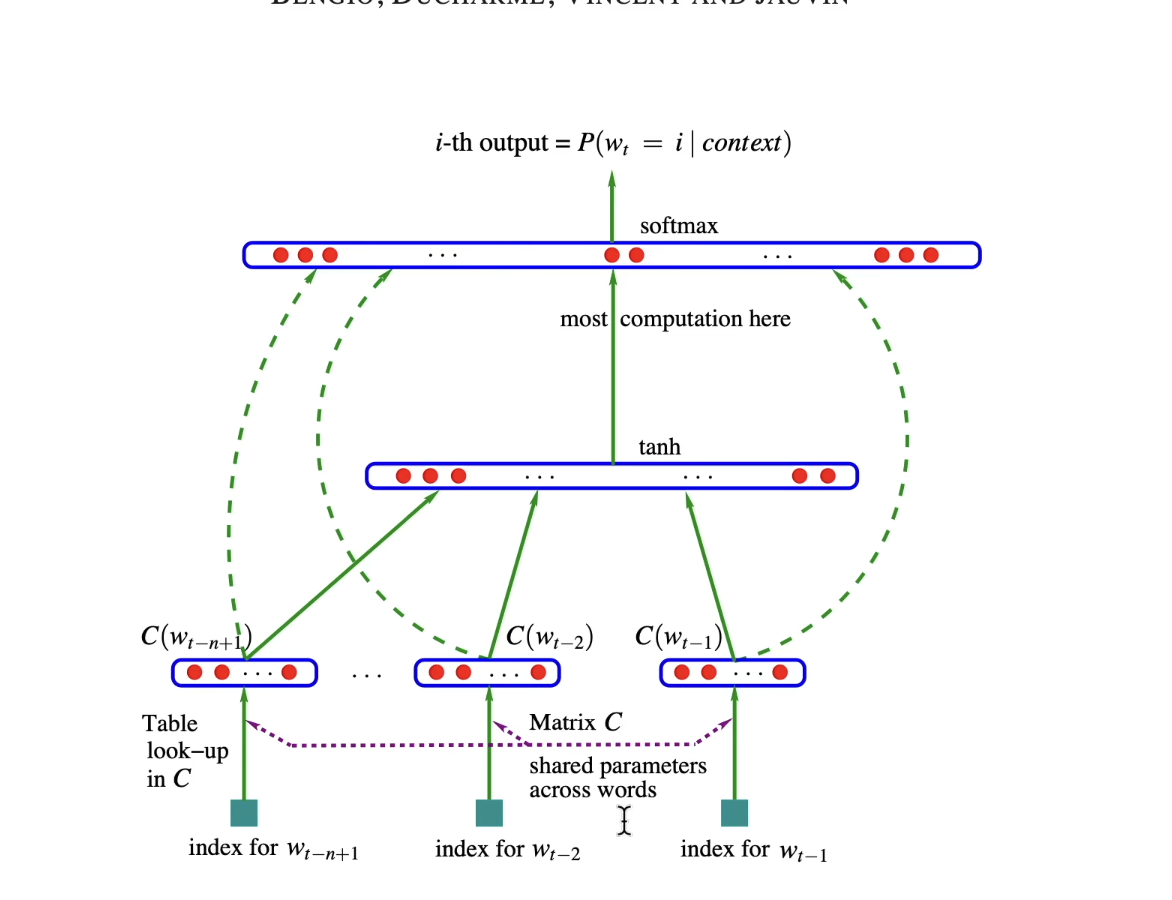

In [537]:
from pathlib import Path
import requests
import numpy as np
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [438]:
data_dir = Path('/Users/djemec/data/gpt_train_data/')
dest = data_dir / 'names' / 'names.txt'

In [439]:
# read all words in
# remove empty lines and makes all things lower case
with open(dest) as f:
    words = [ln.rstrip('\n').lower() for ln in f if ln.strip()]

words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [440]:
# *lines forces character level
stop_char = '.'
chars = sorted(list(set().union(*lines)) + [stop_char])
vocab_size = len(chars) 

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

print(f'total vocab {vocab_size} | chars: {itos}') 

total vocab 27 | chars: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### Split data
80% Training
10% Validation
10% Test

In [657]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + stop_char:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y


block_size = 3 # context window
batch_size = 128

random.seed(123)
random.shuffle(words)

n1 = int(0.8*len(words)) # first 80%
n2 = int(0.9*len(words)) # first 90% so this minus 80% gives 10%

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)



torch.Size([182609, 3]) torch.Size([182609])
torch.Size([22747, 3]) torch.Size([22747])
torch.Size([22790, 3]) torch.Size([22790])


### First must embed our vocab.  
need to cram our 27 characters into a smaller space

In [618]:
g = torch.Generator().manual_seed(12345678)
# 27 characters down to 2 dimensions, will basically feed integers into a weight matric 
dims = 2
C = torch.randn((vocab_size,dims), generator=g)
# hidden layers
num_layers = dims * block_size
num_neurons = 500 # arbitrary number, bigger == more powerful
W1 = torch.randn((num_layers, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g) # one for each neuron
W2 = torch.randn((num_neurons, vocab_size), generator=g) # neurons x vocab size so we get down to vocab layer from each neuron
b2 = torch.randn(vocab_size, generator=g) # one for each vocab
parameters = [C, W1, b1, W2, b2]

In [619]:
sum(p.nelement() for p in parameters) # total number of model parameters

17081

now we have to multiple `emb @ W + b` but emb is [32,3,2] &  W1 is [6,100].  Need to compresse emb's `[3,2]` into a single `[6]` dimensions

* `torch.cat` concatenates tensors, so we can pluck out each `[32,i,2]` vector and concatenate them to get a `[32,6]` 
* `torch.unbind` breaks out a tensor based on the dimension provided, so we'll pick dim 1 
* `torch.split` splits 
* `tensor.view` reshapes a tensor, hope it's right so verify

In [620]:
# requres grad:
for p in parameters:
    p.requires_grad = True

### Learning rate search

In [621]:
# try different learning rates and pick bottom
# lre = torch.linspace(-3, 0, 1000) # learning rate exponent
# lrs = 10**lre
# lrs

In [622]:
lri, lossi, stepi = [], [], []
learning_rate = -0.1
for i in range(100000):
    # initiate batch size
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # since C is a positional embedding, we get for each "letter" stored in C the 2 dimension X embedding
    #torch.cat(torch.unbind(emb, 1), 1).shape # unbinds on dim 1, then concats concatenated on the dim 1, not 0
    h = torch.tanh(emb.view(-1, num_layers) @ W1 + b1) #reshapes, -1 means infer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) # does counts, softmax, neg log likelihood, but helps prevent overflow

    if(i%10000==0):
        print(f'{i}: {loss.item()}')
    # backward pass
    for p in parameters:
        p.grad = None # more efficient than setting to 0
    
    loss.backward() # automatically runs back_prop
    
    # update parameters
    #lr = lrs[i]
    for p in parameters:
        p.data += learning_rate/(round(k/20000)+1) * p.grad

    #lri.append(lre[i])
    if(i%2000==0):
        lossi.append(loss.item())
        stepi.append(i)

0: 33.40509796142578
10000: 2.451075315475464
20000: 2.506598472595215
30000: 2.556767225265503
40000: 2.2236545085906982
50000: 2.365908622741699
60000: 2.389385461807251
70000: 2.3854215145111084
80000: 2.1788551807403564
90000: 2.3411171436309814


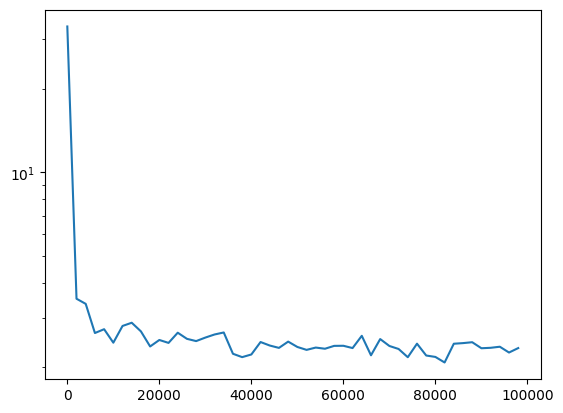

In [623]:
plt.plot(stepi, lossi)
plt.yscale('log')
plt.show()

In [624]:
# want to find min for learning rate
#plt.plot(lri, lossi)

In [625]:
# total loss on training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, num_layers) @ W1 + b1)
logits = h @ W2 + b2
tr_loss = F.cross_entropy(logits, Ytr)
tr_loss.item()

2.319018840789795

In [626]:
# total loss on validation set
emb = C[Xval]
h = torch.tanh(emb.view(-1, num_layers) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, Yval)
val_loss.item(), val_loss.item()-tr_loss.item()

(2.341405153274536, 0.02238631248474121)

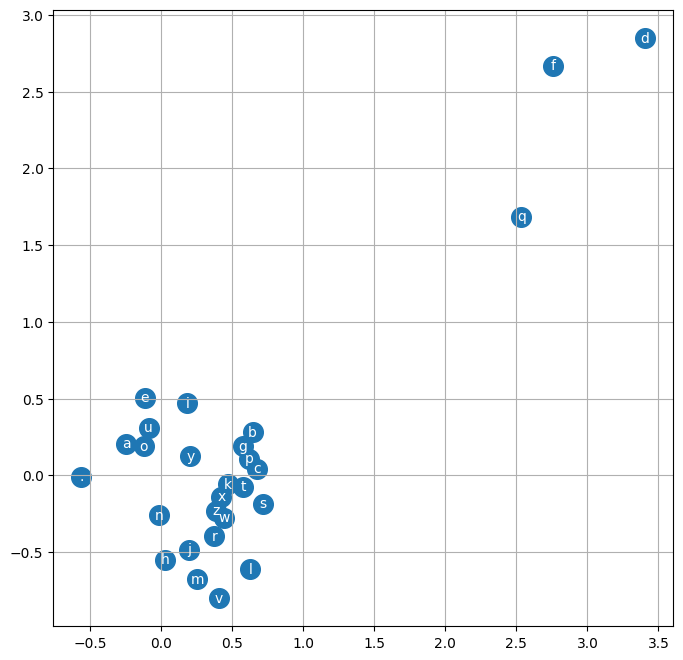

In [628]:
# visualize embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')
plt.show()


## Make more than 2 dimensions in the first layer

In [7]:
from pathlib import Path
import requests
import numpy as np
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [9]:
data_dir = Path('/Users/djemec/data/gpt_train_data/')
dest = data_dir / 'names' / 'names.txt'

In [10]:
# read all words in
# remove empty lines and makes all things lower case
with open(dest) as f:
    words = [ln.rstrip('\n').lower() for ln in f if ln.strip()]

words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [11]:
# *lines forces character level
stop_char = '.'
chars = sorted(list(set().union(*lines)) + [stop_char])
vocab_size = len(chars) 

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

print(f'total vocab {vocab_size} | chars: {itos}') 

total vocab 27 | chars: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [12]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + stop_char:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y


block_size = 4 # context window
batch_size = 256

random.seed(123)
random.shuffle(words)

n1 = int(0.8*len(words)) # first 80%
n2 = int(0.9*len(words)) # first 90% so this minus 80% gives 10%

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)



torch.Size([182427, 4]) torch.Size([182427])
torch.Size([22854, 4]) torch.Size([22854])
torch.Size([22865, 4]) torch.Size([22865])


In [23]:
g = torch.Generator().manual_seed(12345678)
# 27 characters down to 2 dimensions, will basically feed integers into a weight matric 
dims = 25
C = torch.randn((vocab_size,dims), generator=g)
# hidden layers
num_layers = dims * block_size
num_neurons = 500 # arbitrary number, bigger == more powerful
W1 = torch.randn((num_layers, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g) # one for each neuron
W2 = torch.randn((num_neurons, vocab_size), generator=g) # neurons x vocab size so we get down to vocab layer from each neuron
b2 = torch.randn(vocab_size, generator=g) # one for each vocab
parameters = [C, W1, b1, W2, b2]
# requres grad:
for p in parameters:
    p.requires_grad = True

In [24]:
sum(p.nelement() for p in parameters) # total number of model parameters

64702

In [25]:
lri, lossi, stepi = [], [], []

In [35]:
learning_rate = -0.15
l_offset =  max(stepi) if len(stepi)>0 else 0
for i in range(150000):
    # initiate batch size
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # since C is a positional embedding, we get for each "letter" stored in C the 2 dimension X embedding
    #torch.cat(torch.unbind(emb, 1), 1).shape # unbinds on dim 1, then concats concatenated on the dim 1, not 0
    h = torch.tanh(emb.view(-1, num_layers) @ W1 + b1) #reshapes, -1 means infer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) # does counts, softmax, neg log likelihood, but helps prevent overflow

    if(i%10000==0):
        print(f'{i}: {loss.item()}')
    # backward pass
    for p in parameters:
        p.grad = None # more efficient than setting to 0
    
    loss.backward() # automatically runs back_prop
    
    # update parameters
    #lr = lrs[i]
    for p in parameters:
        p.data += learning_rate/(round(i/20000)+1) * p.grad

    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(l_offset+i)

0: 1.9363117218017578
10000: 2.1339383125305176
20000: 2.0208475589752197
30000: 1.8015825748443604
40000: 1.8379738330841064
50000: 1.9868005514144897
60000: 1.9356071949005127
70000: 1.9121119976043701
80000: 1.938987135887146
90000: 1.84516441822052
100000: 1.8360809087753296
110000: 1.9261369705200195
120000: 1.7075064182281494
130000: 1.7696386575698853
140000: 1.8175675868988037


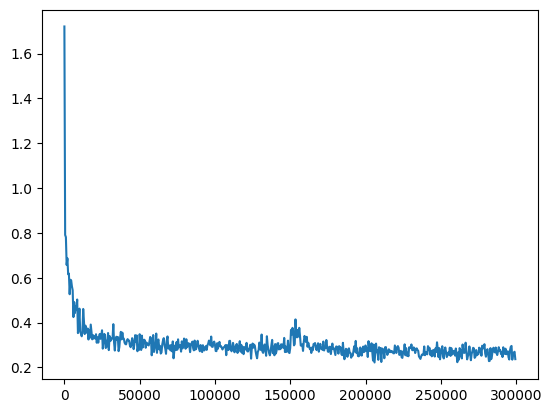

In [36]:
plt.plot(stepi[::500], lossi[::500])
plt.show()

In [37]:
# total loss on training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, num_layers) @ W1 + b1)
logits = h @ W2 + b2
tr_loss = F.cross_entropy(logits, Ytr)
tr_loss.item()

1.8522982597351074

In [38]:
# total loss on validation set
emb = C[Xval]
h = torch.tanh(emb.view(-1, num_layers) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, Yval)
val_loss.item(), val_loss.item()-tr_loss.item()

(2.2534611225128174, 0.40116286277770996)

In [40]:
# total loss on validation set
emb = C[Xte]
h = torch.tanh(emb.view(-1, num_layers) @ W1 + b1)
logits = h @ W2 + b2
test_loss = F.cross_entropy(logits, Yte)
test_loss.item(), test_loss.item()-val_loss.item()

(2.2292871475219727, -0.024173974990844727)

### Sampling

In [41]:
g = torch.Generator().manual_seed(12345678)

In [42]:
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break

    print(''.join([itos[i] for i in out]))
            
        

calem.
garbe.
ango.
enzell.
greyra.
avan.
wolfnex.
badeel.
rahs.
samilynn.
akhama.
asremy.
allus.
brinlee.
dyams.
man.
zalen.
pailyn.
dian.
ezmer.
